# [Seq2Seq and Attention](https://tutorials.pytorch.kr/intermediate/seq2seq_translation_tutorial.html)

## RNN

- Vanilla RNN
> 짧은 시퀀스에 대해서만 효과적임.
- LSTM
> 은닉층의 메모리 셀에 입력 게이트, 망각 게이트, 출력 게이트를 추가하여 불필요한 기억을 지우고, 기억해야할 것들을 정합니다. 즉, RNN보다 긴 시퀀스의 입력에서도 효과적임. 
- GRU
> LSTM에서 출력,입력,망각(삭제) 게이트라는 3개의 게이트가 존재했다면, GRU는 업데이트 게이트와 리셋 게이트 두 가지 게이트만 존재합니다.

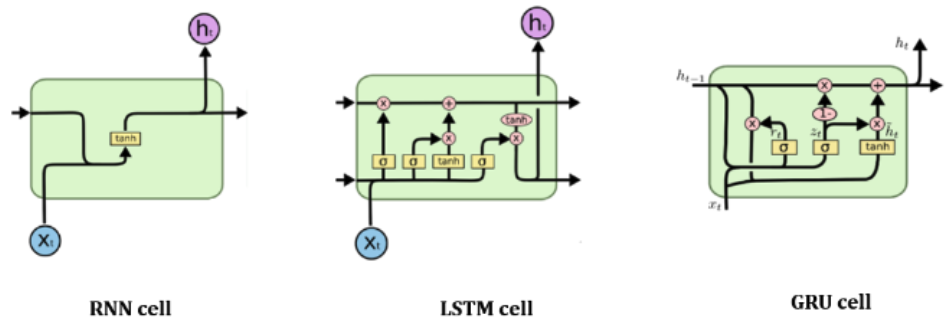

## [Sequence To Sequence](https://heekangpark.github.io/nlp/attention)

### Seq2Seq 동작 방법

- Seq2Seq 모델은 '시퀀스를 받아들이는 부분'과 '시퀀스를 출력하는 부분'을 분리한 것이 특징이다.    
- 이때 시퀀스를 받아들이는 부분(왼쪽 주황색 RNN모듈)을 인코더(encoder), 시퀀스를 출력하는 부분(오른쪽 녹색 RNN모듈)을 디코더(decoder)라 한다.    
- 인코더는 입력 시퀀스(원문)를 받아들여 컨텍스트 벡터(context vector)라 불리는 고정된 크기의 벡터로 변환한다. 디코더는 인코더가 생성한 컨텍스트 벡터를 받아 출력 시퀀스(번역문)를 출력한다.  
  
아래는 인코더와 디코더의 동작을 좀더 자세하게 설명하였다.

#### Encoder
1. 인코더의 은닉 상태를 적절한 값(ex. 영벡터)으로 초기화한다.
2. 매 시점(time step)원문의 단어(token)가 입력되면(단어의 임베딩이 입력되면) 인코더는 이를 이용해 은닉 상태를 업데이트를 한다.
3. 입력 시퀀스의 끝까지 이 과정을 반복하면 인코더의 최종 은닉 상태는 입력 시퀀스의 정보를 압축 요약한 정보를 담고 있게 된다.
4. 이 마지막 시점에서의 인코더 은닉 상태를 컨텍스트 벡터라고 하고, 이 값은 디코더로 넘어간다.

#### Decoder
1. 디코더는 전달받은 컨텍스트 벡터로 자신의 은닉 상태를 초기화한다.
2. 그리고 매 시점 자신이 바로 직전 시점에 출력했던 단어를 입력으로 받아, 자신의 은닉 상태를 업데이트하고, 이를 이용해 다음 단어를 예측한다. (최초 시점에서는 시퀀스 시작을 의미하는 `<sos>` 토큰(Start Of Sequence)을 입력으로 받는다.) 
3. 이 과정을 정해진 반복 횟수 또는 시퀀스 끝을 나타내는 `<eos>` 토큰(End Of Sequence)이 나올 때까지 수행한다.

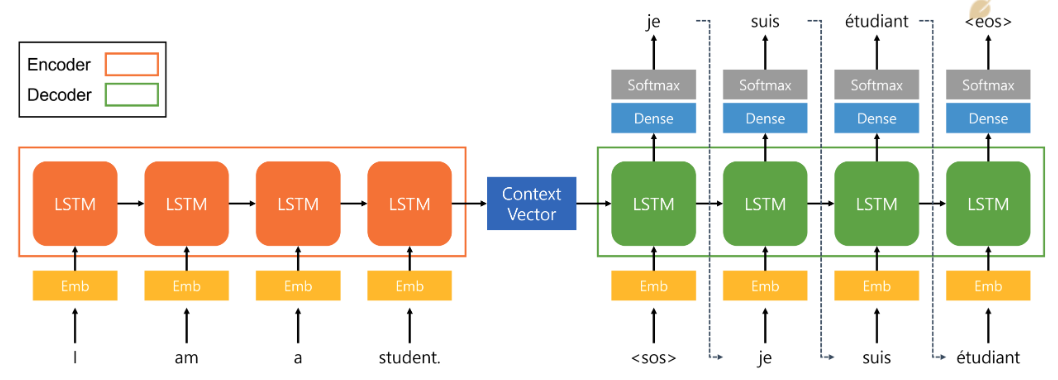

### Seq2Seq 한계

Seq2Seq 모델은 번역(translation), 챗봇 등의 task에서 높은 성능을 보였다. 하지만 Seq2Seq 모델은 커다란 한계가 있었다.

- 입력 시퀸스의 모든 정보를 하나의 고정된 크기의 벡터(컨텍스트 벡터)에 다 압축 요약하려 하다 보니 정보의 손실이 생길 수밖에 없다. 특히 시퀸스의 길이가 길다면 정보의 손실이 더 커진다.
- RNN 구조로 만들어진 모델이다 보니, 필연적으로 gradient vaninshing/exploding 현상이 발생한다.

## [Attention Mechanism](https://blog.floydhub.com/attention-mechanism/)

어텐션 메커니즘은 Seq2Seq 모델의 문제점을 개선하기 위해 제안되었다.   

구체적으로, 어텐션 메커니즘은 다음을 가정한다.  
> 디코더가 단어 X를 출력하기 직전의 디코더 은닉 상태는 인코더가 입력 시퀀스에서 X와 연관이 깊은 단어를 읽은 직후의 인코더 은닉 상태와 유사할 것이다.   

예를 들어 영어 문장 "I am a student."을 한국어 문장 "나는 학생이다."로 번역하는 상황을 생각해 보자. 출력 시퀀스의 단어 "학생"은 입력 시퀀스의 단어 "I", "am", "a", "student", "." 중에서 "student"와 연관이 깊다.    
이때 `어텐션 메커니즘`은 디코더가 "학생"을 출력하기 직전의 은닉 상태는 인코더가 "student"를 입력받은 직후의 은닉 상태와 유사할 것이라고 가정한다.    
따라서 인코더가 "student"를 입력받은 직후의 은닉 상태에 조금 더 "집중"하면, 훨씬 더 품질 높은 번역을 만들 수 있을 것이다.

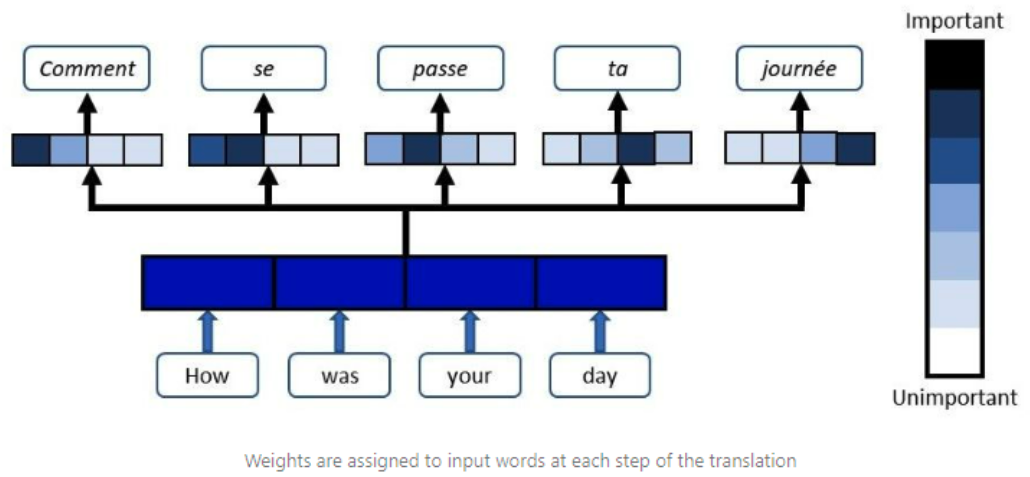

### Attention 동작 방법

어텐션 머커니즘의 동작 과정은 query, key, value라는 이름으로 일반화할 수 있다.  
- 유사도(similarity): 스코어 함수를 이용하여 query와 각 key들 간의 어켄션 스코어를 계산한다.
- 정규화(normalization): softmax 함수를 이용하여 query와 각 key들 간의 어텐션 스코어들을 어텐션 분포로 변환한다.  
- 가중합(weighted sum): 어텐션 분포를 이용해 각 value들의 가중합(어텐션 값)을 구한다.   

즉 어텐션 연산은 query에 대해 value들을 "요약"하는 것이다. 다르게 말하면, 어텐션 연산은 어떤 value에 "집중"할지 결정하는 것이다. 어텐션 연산이 수행되면, 중요한(=query와 유사도가 높은 key를 가진) value에 더 "집중"하게 된다.

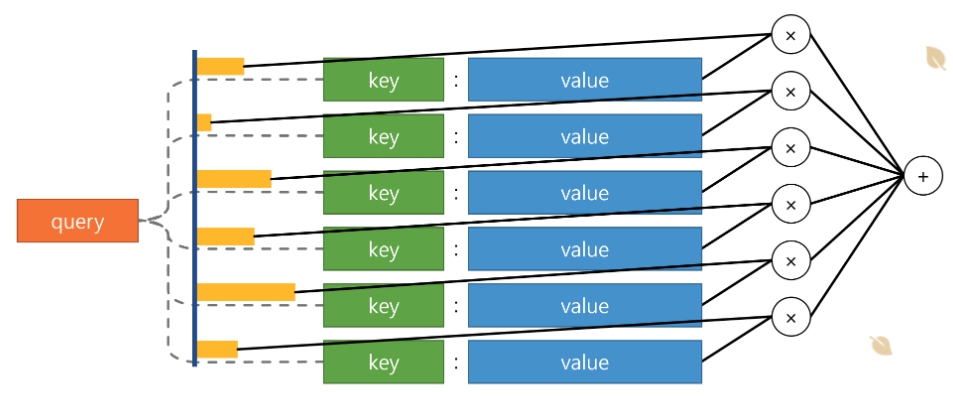

### 스코어 함수

query와 key 사이의 유사도를 구하는 함수를 스코어 함수라고 한다.   
아래 이미지는 유명한 스코어 함수들을 정리한 표이다.

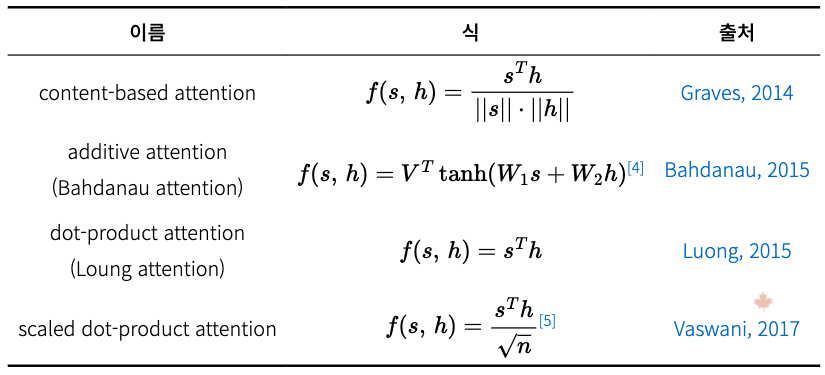

## Seq2Seq with Attention 동작 방법

1. 어느 시점의 인코더 은닉 상태에 조금 더 "집중"해야 하는지 찾기 위해, 현재 디코더의 은닉 상태와 매 시점 인코더의 은닉 상태들 간 "유사도"를 계산한다.  
2. 이 유사도를 확률의 형태로 바꾸고, 그 값에 따라 인코더 은닉 상태들의 가중합(weighted sum)을 구해 "보정된 컨텍스트 벡터"를 구한다.  
3. "보정된 컨텍스트 벡터"을 이용해 다음 단어를 예측한다.  

# 1.데이터 파일 로딩

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

문자 단위 RNN 튜토리얼에서 사용된 문자 인코딩과 유사하게, 언어의 각 단어들을 One-Hot Vector로 표현합니다. 언어마다 수십 개의 문자가 있어서 인코딩 벡터는 매우 큽니다.   
  
그러나 우리는 약간의 트릭을 써서 언어 당 수천 단어만 사용하도록 데이터를 다듬을 것입니다.  

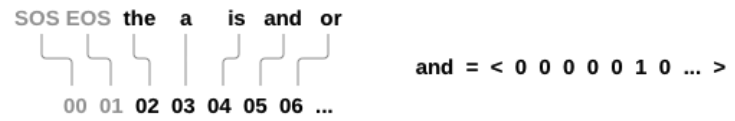

나중에 네트워크의 입력 및 목표로 사용하려면 단어 당 고유 번호가 필요합니다. 이 모든 것을 추적하기 위해 우리는 `단어-색인(word2index)`과 `색인-단어(index2word)` 사전, 그리고 나중에 희구 단어를 대체하는데 사용할 각 `단어의 빈도(word2count)`를 가진 Lang 클라스를 만듭니다.  
  
- SOS token: Start Of String Token
- EOS token: End Of String Token

In [ ]:
SOS_token = 0 # Start Of String Token
EOS_token = 1 # End Of String Token


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # SOS 와 EOS 포함

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

파일은 모두 유니코드로 되어있어 간단하게하기 위해 유니코드 문자를 ASCII로 변환하고, 모든 문자를 소문자로 만들고, 대부분의 구두점을 지워줍니다.

In [ ]:
# 유니 코드 문자열을 일반 ASCII로 변환하십시오.
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# 소문자, 다듬기, 그리고 문자가 아닌 문자 제거
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [ ]:
# 구글 드라이브 연결(데이터 로드를 위해서)
from google.colab import drive
drive.mount('/content/data')

Mounted at /content/data


In [ ]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # 파일을 읽고 줄로 분리
    DATA_PATH = "/content/data/MyDrive/lecture/6. deep learning/7-2. NLP_Pytorch/data/"
    lines = open(DATA_PATH+'%s-%s.txt' % ('eng', 'fra'), encoding='utf-8').\
        read().strip().split('\n')

    # 모든 줄을 쌍으로 분리하고 정규화
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # 쌍을 뒤집고, Lang 인스턴스 생성
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [ ]:
MAX_LENGTH = 10 #최대 길이

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [ ]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [ ]:
input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['j ai raison .', 'i am right .']


# 2.Seq2Seq Model

Sequence to Sequence network, 또는 Seq2Seq 네트워크, 또는 encoder Decoder network는 인코더 및 디코더라고 하는 두 개의 RNN으로 구성된 모델입니다.   
  
인코더는 입력 시퀀스를 읽고 단일 벡터를 출력하고, 디코더는 해당 벡터를 읽어 출력 시퀀스를 생성합니다.

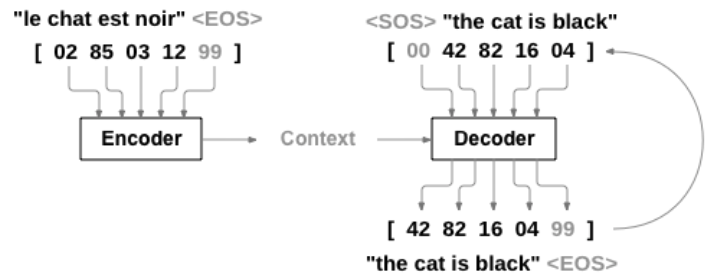

## Encoder

Seq2Seq 네트워크의 인코더는 입력 문장의 모든 단어에 대해 어떤 값을 출력하는 RNN입니다. 모든 입력 단어에 대해 인코더는 벡터와 은닉 상태를 출력하고 다음 입력 단어를 위해 그 은닉 상태를 사용합니다.

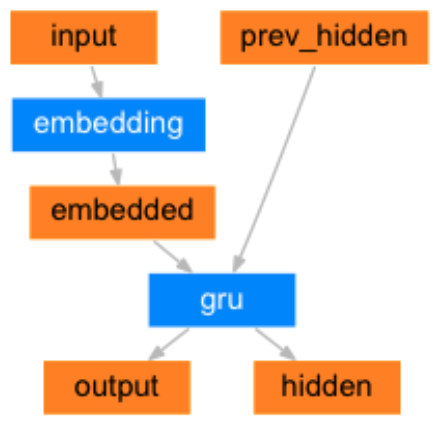

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## Decoder
> 디코더는 인코더 출력 벡터를 받아서 번역을 생성하기 위한 단어 시퀀스를 출력합니다.

### 간단한 디코더
가장 간단한 Seq2Seq 디코더는 인코더의 마지막 출력만을 이용합니다. 이 마지막 출력은 전체 시퀀스에서 문맥을 인코드하기 때문에 문맥 벡터(context vector)로 불립니다. 이 문맥 벡터는 디코더의 초기 인닉 상태로 사용됩니다.

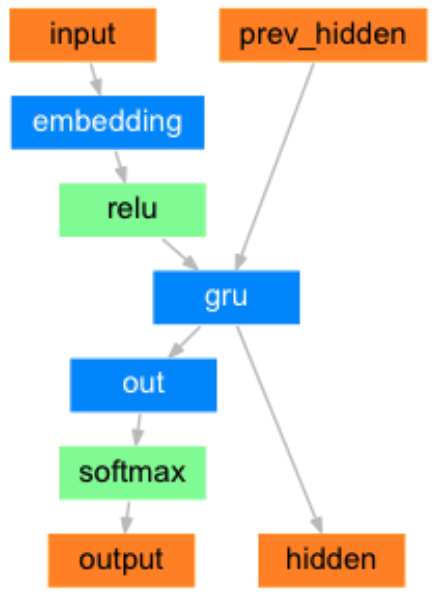

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### Attention 디코더

문맥 벡터(context vector)만 인코더와 디코더 사이로 전달 된다면, 단일 벡터가 전체 문장을 인코딩 해야하는 부담을 가지게 됩니다.   
  
Attention은 디코더 네트워크가 자기 출력의 모든 단계에서 인코더 출력의 다른 부분에 집중 할 수 있게 합니다.

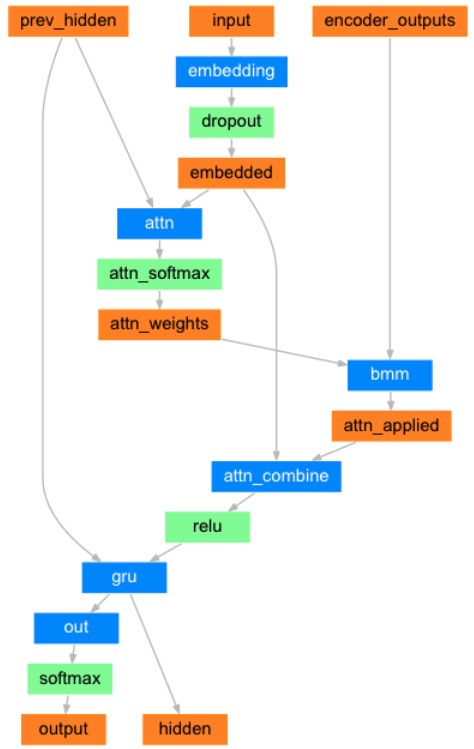

In [ ]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

# 3.학습

## 학습 데이터 준비
> 학습을 위해서, 각 쌍마다 입력 Tensor(입력 문장의 단어 주소)와 목표 Tensor(목표 문장의 단어 주소)가 필요합니다. 이 벡터들을 생성하는 동안 두 시퀀스에 EOS 토큰을 추가 합니다.

In [ ]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

## 모델 학습

학습을 위해서 인코더에 입력 문장을 넣고 모든 출력과 최신 은닉 상태를 추적합니다. 그런 다음 디코더에 첫 번재 입력으로 `<SOS>` 토큰과 인코더의 마지막 은닉 상태가 첫 번째 은닉 상태로 제공됩니다.   

In [ ]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing 포함: 목표를 다음 입력으로 전달
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Teacher forcing 미포함: 자신의 예측을 다음 입력으로 사용
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # 입력으로 사용할 부분을 히스토리에서 분리

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

이것은 현재 시간과 진행률%을 고려해 경과된 시간과 남은 예상 시간을 출력하는 헬퍼 함수입니다.

In [ ]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

> 결과 도식화

In [ ]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # 주기적인 간격에 이 locator가 tick을 설정
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

> 전체 학습 과정
- 타이머 시작
- optimizers와 criterion 초기화
- 학습 쌍의 세트 생성
- 도식화를 위한 빈 손실 배열 시작

In [ ]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # print_every 마다 초기화
    plot_loss_total = 0  # plot_every 마다 초기화

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [
        tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                    decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

# 4.평가

평가는 대부분 학습과 동일하지만 목표가 없으므로 각 단계마다 디코더의 예측을 되돌려 전달합니다.     
단어를 예측할 때마다 그 단어를 출력 문자열에 추가합니다. 만약 `EOS` 토큰을 예측하면 거기에서 멈춥니다.

In [ ]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                    encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

학습 세트에 있는 임의의 문장을 평가하고 입력, 목표 및 출력을 하여 주관적인 품질 판단을 내릴 수 있습니다.

In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

# 5.학습과 평가

In [ ]:
import time

hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

1m 25s (- 19m 51s) (5000 6%) 2.8439
2m 43s (- 17m 44s) (10000 13%) 2.3218
4m 4s (- 16m 16s) (15000 20%) 1.9570
5m 23s (- 14m 49s) (20000 26%) 1.7347
6m 44s (- 13m 28s) (25000 33%) 1.5189
8m 4s (- 12m 6s) (30000 40%) 1.3762
9m 25s (- 10m 45s) (35000 46%) 1.2329
10m 45s (- 9m 24s) (40000 53%) 1.0941
12m 4s (- 8m 3s) (45000 60%) 0.9943
13m 25s (- 6m 42s) (50000 66%) 0.8951
14m 44s (- 5m 21s) (55000 73%) 0.8040
16m 5s (- 4m 1s) (60000 80%) 0.7467
17m 25s (- 2m 40s) (65000 86%) 0.6844
18m 47s (- 1m 20s) (70000 93%) 0.6252
20m 7s (- 0m 0s) (75000 100%) 0.5491


In [ ]:
evaluateRandomly(encoder1, attn_decoder1)

> je ne m implique pas .
= i m not getting involved .
< i m not getting involved . <EOS>

> je ne suis pas sourd .
= i m not deaf .
< i m not deaf . <EOS>

> je suis occupee .
= i m busy .
< i m busy . <EOS>

> il est plutot beau .
= he s kind of handsome .
< he is rather kind of <EOS>

> il est populaire aupres de tout le monde .
= he is popular with everybody .
< he is popular with everybody . <EOS>

> cela m intrigue .
= i m intrigued .
< i am fine . <EOS>

> nous ne sommes pas encore desesperees .
= we re not desperate yet .
< we re not not yet . <EOS>

> c est un homme aux multiples talents .
= he s a man of many talents .
< he s a man to a . . <EOS>

> tu es tres elegante .
= you re very stylish .
< you re very sophisticated . <EOS>

> vous ne m ecoutez pas .
= you re not listening to me .
< you re not helping me . <EOS>



## Atention 시각화

Attention 메커니즘의 유용한 속성은 하나는 해석 가능성이 높은 출력입니다. 입력 시퀀스의 특정 인코더 출력에 가중치를 부요하는 데 사용되므로 각 시간 단계에서 네트워크가 가장 집중되는 위치를 파악할 수 있습니다. 

In [ ]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid .")
plt.matshow(attentions.numpy())

더 나은 보기를 위해 축과 라벨을 더하는 추가 작업응ㄹ 수행합니다.

In [ ]:
def showAttention(input_sentence, output_words, attentions):
    # colorbar로 그림 설정
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # 축 설정
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                        ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # 매 틱마다 라벨 보여주기
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [ ]:
def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

In [ ]:
evaluateAndShowAttention("elle a cinq ans de moins que moi .")

input = elle a cinq ans de moins que moi .
output = she is five years younger than me . <EOS>


<ipython-input-29-6c6995293660>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-29-6c6995293660>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


In [ ]:
evaluateAndShowAttention("elle est trop petit .")

input = elle est trop petit .
output = she is too drunk . <EOS>


<ipython-input-29-6c6995293660>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-29-6c6995293660>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


In [ ]:
evaluateAndShowAttention("je ne crains pas de mourir .")

input = je ne crains pas de mourir .
output = i m not afraid of dying . <EOS>


<ipython-input-29-6c6995293660>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-29-6c6995293660>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


In [ ]:
evaluateAndShowAttention("c est un jeune directeur plein de talent .")

input = c est un jeune directeur plein de talent .
output = he s a lovely young . . . <EOS>


<ipython-input-29-6c6995293660>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-29-6c6995293660>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)
